# <span style="color:orange"> Monoasset test: Pricing Geometric Average Asian Option </span>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from pricing import DiscountingCurve, EquityForwardCurve, Black, Vanilla_PayOff,ForwardVariance
from montecarlo import MC_Analisys, MC
import time, sys
import lets_be_rational.LetsBeRational as lbr
import matplotlib.ticker as mticker
from scipy.stats.mstats import gmean
from closedforms import GA_Asian_option_closed_form, European_option_closed_form, volatility_asian, interest_rate_asian
from scipy import log, sqrt, exp

### Parameters of Simulation

In [2]:
t = 0
spot_price = 150
N_simulations = 1e6
N_averages = 30
T_max = 10
maturity = 4.
dates = np.linspace(0.,maturity,N_averages)
r = 1./100
volatility = 20./100

### Market Data


In [3]:
"""Discounut Factors"""
zero_interest_rate = np.array([r,r,r])
zero_interest_rate_dates = np.array([0.01,5,T_max])
d = exp(-zero_interest_rate*zero_interest_rate_dates)        #market discount factors 
D = DiscountingCurve(reference=t, discounts=d, dates=zero_interest_rate_dates)   #discounting curve
F = EquityForwardCurve(reference=t, discounting_curve=D, spot=spot_price,repo_dates=np.array([0.1,T_max]), repo_rates=np.array([0.,0.]))

Forward interest rate time grid [ 0.01  5.   10.  ]
Forward interest rate:  [0.01 0.01 0.01]
Forward repo time grid [ 0.1 10. ]
Forward repo rate:  [0. 0.]


In [4]:
K_spot_vola = np.array([spot_price,200])
spot_vol = np.array(([volatility,volatility],[0.3,0.3]))
spot_vol_dates = np.array([0.1,T_max])
V = ForwardVariance(reference=t,maturities=spot_vol_dates,strikes=K_spot_vola,spot_volatility=spot_vol,strike_interp=spot_price)

Forward volatility time grid:  [ 0.1 10. ]
Forward volatility:  [0.2 0.2]


### Simulation

In [5]:
B_model = Black(variance=V, forward_curve=F)
S_t = B_model.simulate(fixings=dates, Nsim=N_simulations, seed=8)
G_mean = gmean(S_t,axis=1)

Single Asset Simulation


In [6]:
K = spot_price
kind = 1
pay = Vanilla_PayOff(St=G_mean,strike=K, typo = kind)*D(maturity)
right = GA_Asian_option_closed_form(forward = F(maturity), strike= K, maturity=maturity, reference=t, zero_interest_rate = r, volatility=volatility, N_averages=N_averages, typo = kind)

### Convergence Check

In [7]:
x,mean,err = MC_Analisys(pay,100)

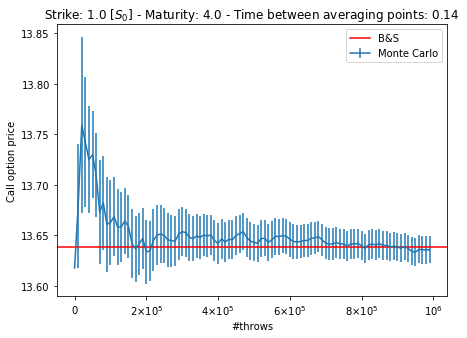

In [8]:
nu = dates[1]-dates[0]
plt.figure(figsize=(7,5))
plt.axhline(y=right, color = 'red',linestyle='-',label = 'B&S')
plt.errorbar(x,mean,yerr=err,label = 'Monte Carlo')
plt.xlabel('#throws')
plt.legend()
f = mticker.ScalarFormatter(useOffset=False, useMathText=True)
g = lambda x,pos : "${}$".format(f._formatSciNotation('%1.10e' % x))
plt.gca().xaxis.set_major_formatter(mticker.FuncFormatter(g))
plt.title("Strike: "+str(K/spot_price)+" [$S_0$] - Maturity: "+str(maturity)+" - Time between averaging points: "+str(round(nu,2)))
if kind==1:
    plt.ylabel('Call option price')
   # plt.savefig('Graphs/Asian_call_option.pdf')
elif kind==-1:
    plt.ylabel('Put option price')
    #plt.savefig('Graphs/Asian_put_option.pdf')
plt.show()

/home/ste/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """


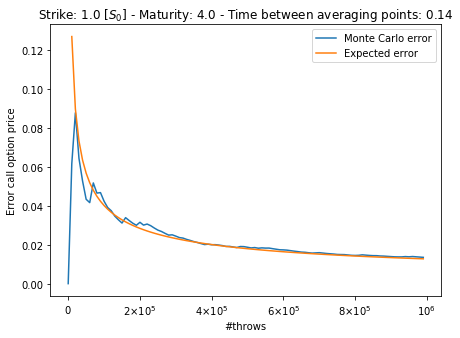

In [9]:
z = np.std(pay)
y = np.sqrt(x)
plt.figure(figsize=(7,5))
plt.plot(x,err, label = 'Monte Carlo error')
plt.plot(x,z/y, label = 'Expected error')
plt.xlabel("#throws")
f = mticker.ScalarFormatter(useOffset=False, useMathText=True)
g = lambda x,pos : "${}$".format(f._formatSciNotation('%1.10e' % x))
plt.gca().xaxis.set_major_formatter(mticker.FuncFormatter(g))
plt.title("Strike: "+str(K/spot_price)+" [$S_0$] - Maturity: "+str(maturity)+" - Time between averaging points: "+str(round(nu,2)))
plt.legend()
if kind==1:
    plt.ylabel('Error call option price')
    #plt.savefig('Graphs/Error_asian_call_option.pdf')
elif kind==-1:
    plt.ylabel('Error put option price')
   # plt.savefig('Graphs/Error_asian_put_option.pdf')

plt.show()

### Implied volatility in function of Log-moneyness log(K/F)

In [ ]:
logmoneyness =np.arange(-10,11)*0.1
maturities = np.arange(1,31)*0.15
N_averages = 30
imp_volatility = np.zeros((len(logmoneyness),len(maturities)))
imp_volatility_plus = np.zeros((len(logmoneyness),len(maturities)))
imp_volatility_minus = np.zeros((len(logmoneyness),len(maturities)))
start_time = time.time()
for i in range(len(maturities)):
    if i%10 == 0:
        print("Running: ",i,"%")
    dates = np.linspace(0.,maturities[i],N_averages)
    S_t = B_model.simulate(fixings=dates, Nsim=N_simulations, seed=8)
    G_mean = gmean(S_t,axis=1)    
    for j in range(len(logmoneyness)):
        if logmoneyness[j]>=0.:
            kind =1
        elif logmoneyness[j]<0.:
            kind =-1
        K = np.exp(logmoneyness[j])
        forward = spot_price*exp(r_asian(N_averages,r,volatility)*maturities[i])
        X_t = G_mean/forward
        E = np.mean(X_t,axis=0)
        option = Vanilla_PayOff(St=X_t, strike=K,typo=kind)
        result, err_result = MC(option)
        imp_volatility[j][i] = lbr.implied_volatility_from_a_transformed_rational_guess(result,E,K,maturities[i],kind)
        imp_volatility_plus[j][i] = lbr.implied_volatility_from_a_transformed_rational_guess(result+err_result,E,K,maturities[i],kind)
        imp_volatility_minus[j][i] = lbr.implied_volatility_from_a_transformed_rational_guess(result-err_result,E,K,maturities[i],kind)
        
print("Execution time: ---%s min ---" %((time.time()-start_time)/60))
print("Saving_Files...")
print("COMPLETED")

In [11]:
asian_vola = volatility_asian(N_averages,volatility)
y_lower = np.zeros((len(logmoneyness),len(maturities)))
y_upper = np.zeros((len(logmoneyness),len(maturities)))
for i in range(len(logmoneyness)):
     for j in range(len(maturities)):
            if(imp_volatility_minus[i][j]<imp_volatility_plus[i][j]):
                y_lower[i][j] = abs(imp_volatility[i][j]-imp_volatility_minus[i][j])
                y_upper[i][j] = abs(imp_volatility_plus[i][j]-imp_volatility[i][j])
            elif(imp_volatility_minus[i][j]>imp_volatility_plus[i][j]):
                y_lower[i][j] = abs(imp_volatility[i][j]-imp_volatility_plus[i][j])
                y_upper[i][j] = abs(imp_volatility_minus[i][j]-imp_volatility[i][j])


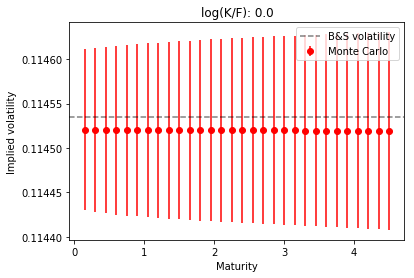

In [12]:
"""Fixed Strike"""  #ATM = 5
num = [10]    # 0, 5, 15
c=2
for i in range(len(num)):
    err_lower = y_lower[num[i]]
    err_upper = y_upper[num[i]]
    plt.errorbar(maturities,imp_volatility[num[i]],yerr=[err_lower,err_upper],fmt="o",color = "red",label="Monte Carlo")
    plt.title("log(K/F): "+str(round(logmoneyness[num[i]],c)))

plt.axhline(y=asian_vola, color = 'black',alpha = 0.5,linestyle='--',label = 'B&S volatility')
plt.xlabel("Maturity")
plt.ylabel("Implied volatility")
plt.legend()
#plt.savefig("implied_basket_atm.pdf")
plt.show()

[0.00170678 0.00098722 0.00058427 0.00036778 0.00025476 0.0001937
 0.00016133 0.00014552 0.00013985 0.00013881 0.0002229  0.00020354
 0.00019559 0.00020209 0.00022733 0.0002807  0.0003815  0.00057406
 0.00092729 0.00154029 0.002712  ]


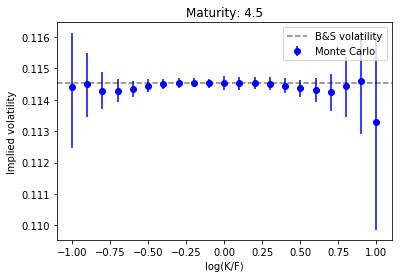

In [13]:
"""Fixed Maturity"""
num = [29]  #0, 6, 39
c=1
for i in range(len(num)):
    err_lower = 2*y_lower.T[num[i]]
    err_upper = 2*y_upper.T[num[i]]
    plt.errorbar(logmoneyness,imp_volatility.T[num[i]],yerr=[err_lower,err_upper],fmt="o",color="blue",label="Monte Carlo")
plt.axhline(y=asian_vola, color = 'black',alpha = 0.5,linestyle='--',label = 'B&S volatility')  
plt.xlabel("log(K/F)")
plt.ylabel("Implied volatility")
plt.title("Maturity: "+str(round(maturities[num[i]],c)))
plt.legend()
#plt.savefig("Graphs/implied_vol_logmaturity"+str(round(maturities[num[i]],c))+".pdf")
plt.show()

## OTHER RESULTS IN TERM OF PRICE

In [ ]:
x = np.arange(1,21)*10
media = np.zeros(len(x))
errore = np.zeros(len(x))
for i in range(len(x)):
    fixings = np.linspace(ref,maturity,x[i])
    S_t = B_model.simulate(fixings=fixings, Nsim=1e6, seed=2)
    G_mean = gmean(S_t,axis=1)
    pay = Vanilla_PayOff(St=G_mean,strike=strike, typo = kind)*D(maturity)
    mean, err = MC(pay)
    media[i] = mean
    errore[i] = err
   
    
np.savetxt("Results/Asian_frequence.txt",media)
np.savetxt("Results/Asian_frequence_err.txt",errore)
np.savetxt("Results/frequence_asian.txt",x)

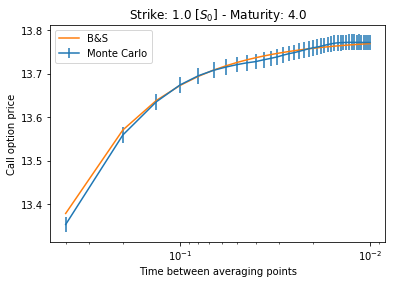

In [10]:
x = np.loadtxt("Results/frequence_asian.txt")
media = np.loadtxt("Results/Asian_frequence.txt")
errore = np.loadtxt("Results/Asian_frequence_err.txt")
nu = maturity/x
closed = GA_Asian_option_closed_form(forward = F(maturity), strike= K, maturity=maturity, reference=t, zero_interest_rate = r, volatility=volatility, N_averages=x, typo = kind)
plt.errorbar(nu,media,yerr=errore, label = 'Monte Carlo')
plt.plot(nu,closed,label='B&S')
plt.xlabel('Time between averaging points')
plt.gca().invert_xaxis()
plt.title("Strike: "+str(K/spot_price)+" [$S_0$] - Maturity: "+str(maturity))
plt.xscale("Log")
plt.legend()
if kind==1:
    plt.ylabel('Call option price')
 #   plt.savefig('Graphs/Asian_call_number.pdf')
elif kind==-1:
    plt.ylabel('Put option price')
  #  plt.savefig('Graphs/Asian_put_number.pdf')
plt.show()


In [57]:
x = np.arange(1,51)*(spot_price*0.25)
m = 100  #number of means before maturity
maturity = 4.0
fixings = np.linspace(reference,maturity,m)
media = np.zeros(len(x))
errore = np.zeros(len(x))
S_t = B_model.simulate(fixings=fixings, Nsim=1e6, seed=2)
G_mean = gmean(S_t,axis=1)
for i in range(len(x)):
    pay = Vanilla_PayOff(St=G_mean,strike=x[i], typo = kind)*D(maturity)
    mean, err = MC(pay)
    media[i] = mean
    errore[i] = err

np.savetxt("Results/Asian_strike.txt",media)
np.savetxt("Results/Asian_strike_err.txt",errore)
np.savetxt("Results/strike_asian.txt",x)

Single Asset Simulation


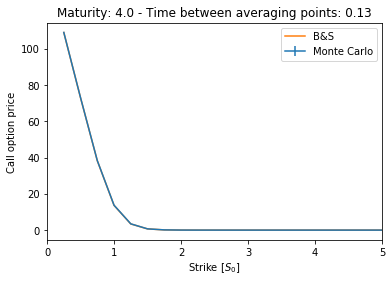

In [12]:
x = np.loadtxt("Results/strike_asian.txt")
media = np.loadtxt("Results/Asian_strike.txt")
errore = np.loadtxt("Results/Asian_strike_err.txt")
closed = GA_Asian_option_closed_form(forward = F(maturity), strike= x, maturity=maturity, reference=t, zero_interest_rate = r, volatility=volatility, N_averages=N_averages, typo = kind)
plt.errorbar(x/spot_price,media,yerr=errore, label = 'Monte Carlo')
plt.plot(x/spot_price,closed,label='B&S')
plt.xlabel('Strike [$S_0$]')
plt.title("Maturity: "+str(maturity)+" - Time between averaging points: "+str(round(maturity/N_averages,2)))
plt.xlim(0,5)
plt.legend()
if kind==1:
    plt.ylabel('Call option price')
   # plt.savefig('Graphs/Asian_call_strike.pdf')
elif kind==-1:
    plt.ylabel('Put option price')
    #plt.savefig('Graphs/Asian_put_strike.pdf')
plt.show()


In [ ]:
x = np.arange(1,41)*0.25
media = np.zeros(len(x))
errore = np.zeros(len(x))
for i in range(len(x)):
    fixings = np.linspace(reference,x[i],m)
    S_t = B_model.simulate(fixings=fixings, Nsim=1e5, seed=2)
    G_mean = gmean(S_t,axis=1)
    pay = Vanilla_PayOff(St=G_mean,strike=strike, typo = kind)*D(x[i])
    mean, err = MC(pay)
    media[i] = mean
    errore[i] = err
   
np.savetxt("Results/Asian_maturity.txt",media)
np.savetxt("Results/Asian_maturity_err.txt",errore)
np.savetxt("Results/maturity_asian.txt",x)

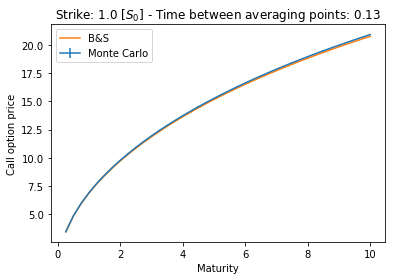

In [15]:
x = np.loadtxt("Results/maturity_asian.txt")
media = np.loadtxt("Results/Asian_maturity.txt")
errore = np.loadtxt("Results/Asian_maturity_err.txt")
closed = GA_Asian_option_closed_form(forward = F(x), strike= K, maturity=x, reference=t, zero_interest_rate = r, volatility=volatility, N_averages=N_averages, typo = kind)
plt.errorbar(x,media,yerr=errore, label = 'Monte Carlo')
plt.plot(x,closed,label='B&S')
plt.xlabel('Maturity')
plt.title("Strike: "+str(K/spot_price)+" [$S_0$] - Time between averaging points: "+str(round(maturity/N_averages,2)))
plt.legend()
if kind==1:
    plt.ylabel('Call option price')
  #  plt.savefig('Graphs/Asian_call_maturity.pdf')
elif kind==-1:
    plt.ylabel('Put option price')
   # plt.savefig('Graphs/Asian_put_maturity.pdf')
plt.show()

### Asian VS European

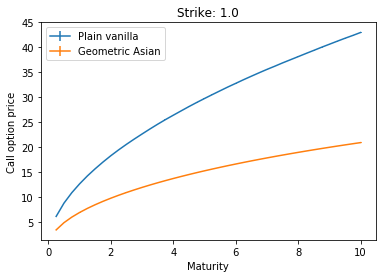

In [6]:
x = np.loadtxt("Results/maturity_asian.txt")
media = np.loadtxt("Results/Asian_maturity.txt")
errore = np.loadtxt("Results/Asian_maturity_err.txt")
euro = np.loadtxt("Results/European_call_maturity.txt")
euro_err = np.loadtxt("Results/European_call_err_maturity.txt")
plt.errorbar(x,euro,yerr=euro_err, label = 'Plain vanilla')
plt.errorbar(x,media,yerr=errore, label = 'Geometric Asian')
plt.xlabel('Maturity')
plt.title("Strike: "+str(K/spot_price))
plt.legend()
if kind==1:
    plt.ylabel('Call option price')
    plt.savefig('Graphs/Asian_euro_call_maturity.pdf')
elif kind==-1:
    plt.ylabel('Put option price')
    plt.savefig('Graphs/Asian_euro_put_maturity.pdf')
plt.show()

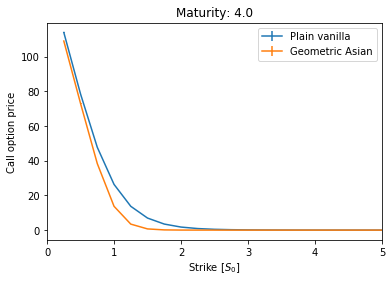

In [7]:
x = np.loadtxt("Results/strike_asian.txt")
media = np.loadtxt("Results/Asian_strike.txt")
errore = np.loadtxt("Results/Asian_strike_err.txt")
euro = np.loadtxt("Results/European_call_strike.txt")
euro_err = np.loadtxt("Results/European_call_err_strike.txt")

plt.errorbar(x/spot_price,euro,yerr=euro_err, label = 'Plain vanilla')
plt.errorbar(x/spot_price,media,yerr=errore, label = 'Geometric Asian')
plt.xlabel('Strike [$S_0$]')
plt.title("Maturity: "+str(maturity))
plt.xlim(0,5)
plt.legend()
if kind==1:
    plt.ylabel('Call option price')
    plt.savefig('Graphs/Asian_euro_call_strike.pdf')
elif kind==-1:
    plt.ylabel('Put option price')
    plt.savefig('Graphs/Asian_euro_put_strike.pdf')
plt.show()